# Summary

A new set of features is being engineered in order to be fed into a new model. The features are token counts calculated on article titles and content excerpts combined together.

Model containing the new features is clearly better than both the baseline model and the model currently in production (even after retraining).

# Setup

In [1]:
%config Completer.use_jedi = False

In [2]:
import sys
import os
import pickle
import re

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import CountVectorizer

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from dataprep import db_to_df, derive_content_length

# Data preparation

In [3]:
articles = db_to_df(path='../site.db')
articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 1 to 73
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   author                          55 non-null     object 
 1   title                           73 non-null     object 
 2   url                             73 non-null     object 
 3   published_at                    73 non-null     object 
 4   content                         69 non-null     object 
 5   source_name                     73 non-null     object 
 6   predicted_score_when_presented  73 non-null     float64
 7   assigned_score                  73 non-null     int64  
 8   is_test_record                  73 non-null     int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 5.7+ KB


In [4]:
articles['published_at'] = pd.to_datetime(articles['published_at'])

In [5]:
articles.head()

,author,title,url,published_at,content,source_name,predicted_score_when_presented,assigned_score,is_test_record
id,,,,,,,,,
1,Tyler Sullivan,"2022 NFL Free Agency tracker: Live updates, la...",https://www.cbssports.com/nfl/news/2022-nfl-fr...,2022-03-15 14:35:03+00:00,The dominos are continuing to fall across the ...,CBS Sports,50.0,-999,0
2,"By <a href=""/profiles/jessie-yeung"">Jessie Yeu...",Russia invades Ukraine: Live updates - CNN,https://www.cnn.com/europe/live-news/ukraine-r...,2022-03-05 06:27:00+00:00,"Russia is poised to deploy up to 1,000 more me...",CNN,50.0,-999,1
3,"By <a href=""/profiles/jessie-yeung"">Jessie Yeu...",Russia invades Ukraine: Live updates - CNN,https://www.cnn.com/europe/live-news/ukraine-r...,2022-03-05 06:27:00+00:00,"Russia is poised to deploy up to 1,000 more me...",CNN,50.0,95,0
4,None,Apple presses U.S. lawmakers on dangers of 'si...,https://www.reuters.com/technology/apple-press...,2022-03-04 22:13:00+00:00,"WASHINGTON, March 4 (Reuters) - Smartphone mak...",Reuters,50.0,50,1
5,Brent Sobleski,Top 5 Potential Landing Spots for Dallas Cowbo...,https://bleacherreport.com/articles/2954024-to...,2022-03-04 22:34:10+00:00,Ron Schwane/Associated Press\r\nMuch like Coop...,Bleacher Report,50.0,0,0


In [6]:
# drop dummy records

n_rows_bef = len(articles)
articles = articles[articles['assigned_score']!=-999]
n_rows_after = len(articles)
print(f'{n_rows_bef - n_rows_after} rows dropped.')

3 rows dropped.


In [7]:
# drop duplicates

n_rows_bef = len(articles)
articles = articles.drop_duplicates(subset=['title', 'published_at'])
n_rows_after = len(articles)
print(f'{n_rows_bef - n_rows_after} rows dropped.')

0 rows dropped.


In [8]:
# drop records with no content

n_rows_bef = len(articles)
articles.dropna(subset='content', inplace=True)
n_rows_after = len(articles)
print(f'{n_rows_bef - n_rows_after} rows dropped.')

4 rows dropped.


In [9]:
articles['content_length_chars'] = articles.apply(derive_content_length, axis=1)

In [10]:
# drop records with no content length

n_rows_bef = len(articles)
articles.dropna(subset='content_length_chars', inplace=True)
n_rows_after = len(articles)
print(f'{n_rows_bef - n_rows_after} rows dropped.')

1 rows dropped.


In [11]:
training = articles[articles['is_test_record']==0].copy()
test = articles[articles['is_test_record']==1].copy()

print(f'Number of training records: {len(training)}')
print(f'Number of test records: {len(test)}')

Number of training records: 32
Number of test records: 33


## Adding token counts

In [12]:
vectorizer = CountVectorizer()

In [13]:
training['title_plus_content'] = training['title'] + training['content']

In [14]:
vectorizer.fit(training['title_plus_content'])

CountVectorizer()

In [15]:
token_cols = vectorizer.get_feature_names_out()
token_cols = ['token_count_' + token for token in token_cols]
token_cols[:5]

['token_count_000',
 'token_count_10',
 'token_count_100',
 'token_count_1098',
 'token_count_1174']

In [16]:
token_vectors = vectorizer.transform(training['title_plus_content']).toarray()
token_vectors = pd.DataFrame(token_vectors, columns=token_cols)
token_vectors.columns = token_vectors.columns.astype(str)
token_vectors.head()

,token_count_000,token_count_10,token_count_100,token_count_1098,token_count_1174,token_count_1259,token_count_13162,token_count_140mm,token_count_1425,token_count_1474,...,token_count_would,token_count_wr,token_count_year,token_count_years,token_count_york,token_count_you,token_count_young,token_count_your,token_count_zelenskiy,token_count_zone
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
training.reset_index(inplace=True)
training = pd.concat([training, token_vectors], axis=1)
training.head()

,id,author,title,url,published_at,content,source_name,predicted_score_when_presented,assigned_score,is_test_record,...,token_count_would,token_count_wr,token_count_year,token_count_years,token_count_york,token_count_you,token_count_young,token_count_your,token_count_zelenskiy,token_count_zone
0,3,"By <a href=""/profiles/jessie-yeung"">Jessie Yeu...",Russia invades Ukraine: Live updates - CNN,https://www.cnn.com/europe/live-news/ukraine-r...,2022-03-05 06:27:00+00:00,"Russia is poised to deploy up to 1,000 more me...",CNN,50.0,95,0,...,0,0,0,0,0,0,0,0,0,0
1,5,Brent Sobleski,Top 5 Potential Landing Spots for Dallas Cowbo...,https://bleacherreport.com/articles/2954024-to...,2022-03-04 22:34:10+00:00,Ron Schwane/Associated Press\r\nMuch like Coop...,Bleacher Report,50.0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,7,"Sophia Saifi, Saleem Mehsud",ISIS claims responsibility for blast killing d...,https://www.cnn.com/2022/03/04/asia/pakistan-p...,2022-03-05 08:41:00+00:00,The Islamic State (ISIS) has claimed responsib...,CNN,50.0,72,0,...,0,0,0,0,0,0,0,0,0,0
3,10,Emily Schmall,Build a New City or New Humans? A Utopia in In...,https://www.nytimes.com/2022/03/05/world/asia/...,2022-03-05 10:18:08+00:00,The stance of those opposed to the development...,New York Times,50.0,35,0,...,1,0,0,0,1,0,0,0,0,0
4,12,Sam Tabahriti,Musk: Starlink won't block Russian media unles...,https://www.businessinsider.com/elon-musk-star...,2022-03-05 10:35:02+00:00,SpaceX's Elon Musk tweeted on Saturday that St...,Business Insider,50.0,55,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
test['title_plus_content'] = test['title'] + test['content']

token_vectors = vectorizer.transform(test['title_plus_content']).toarray()
token_vectors = pd.DataFrame(token_vectors, columns=token_cols)
token_vectors.columns = token_vectors.columns.astype(str)

test.reset_index(inplace=True)
test = pd.concat([test, token_vectors], axis=1)
test.head()

,id,author,title,url,published_at,content,source_name,predicted_score_when_presented,assigned_score,is_test_record,...,token_count_would,token_count_wr,token_count_year,token_count_years,token_count_york,token_count_you,token_count_young,token_count_your,token_count_zelenskiy,token_count_zone
0,4,None,Apple presses U.S. lawmakers on dangers of 'si...,https://www.reuters.com/technology/apple-press...,2022-03-04 22:13:00+00:00,"WASHINGTON, March 4 (Reuters) - Smartphone mak...",Reuters,50.0,50,1,...,0,0,0,0,0,0,0,0,0,0
1,6,None,Evacuations halted as Ukraine accuses Russia o...,https://www.cbsnews.com/live-updates/russia-uk...,2022-03-05 14:06:00+00:00,A cease-fire was planned in the strategic port...,CBS News,50.0,90,1,...,0,0,0,0,0,0,0,0,0,0
2,8,The Sun,'Good Times' actor Johnny Brown dead at 84 - N...,https://nypost.com/2022/03/05/johnny-brown-goo...,2022-03-05 09:28:00+00:00,Beloved Good Times actor Johnny Brown has died...,New York Post,50.0,10,1,...,0,0,0,1,1,0,0,0,0,0
3,9,"Michelle Hackman, Alicia Caldwell",Title 42 border policy for expelling immigrant...,https://www.wsj.com/articles/court-upholds-fed...,2022-03-05 10:01:22+00:00,WASHINGTONThe U.S. government can continue to ...,The Wall Street Journal,50.0,45,1,...,0,0,0,0,0,0,0,0,0,0
4,14,"Marc Santora, Shashank Bengali",Ukraine-Russia War: Live News and Updates - Th...,https://www.nytimes.com/live/2022/03/06/world/...,2022-03-06 14:37:32+00:00,JERUSALEM A day after his surprise meeting at ...,New York Times,50.0,90,1,...,1,0,0,0,1,0,0,0,0,0


# EDA

<AxesSubplot:xlabel='assigned_score', ylabel='Count'>

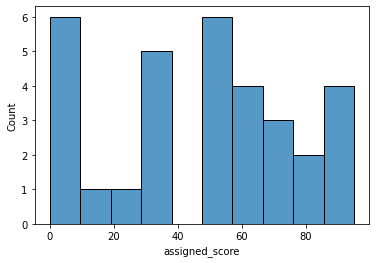

In [19]:
sns.histplot(training['assigned_score'], bins=10)
# assigned score is the target value assigned by the user

Values between 10 and 30 as well as those between 40 and 50 seem to be very scarce in the dataset. This may impede the model's ability to predict.

In [20]:
print(len(training))
print(training['author'].nunique())

32
26


Out of 32 records, 26 have a unique author. This means the feature is not likely to be helpful for most of the records.

In [21]:
print(len(training))
print(training['source_name'].nunique())

32
19


Out of 32 records, 19 have a unique source. This is better than authors, but still may not bring too much information. This should improve as more data is gathered as sources are much less numerous in the real world than authors. In other words, while gathering more data, it's likely that the sources will constantly reappear.

<AxesSubplot:xlabel='content_length_chars', ylabel='Count'>

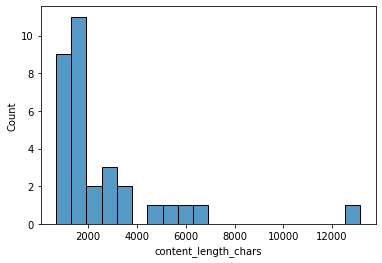

In [22]:
sns.histplot(training['content_length_chars'], bins=20)

Around three quarters of articles have their length under 2000 characters.

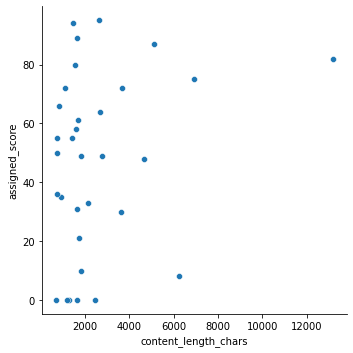

In [23]:
sns.relplot(x='content_length_chars', y='assigned_score', data=training)

In [24]:
corr = np.corrcoef(training['content_length_chars'], training['assigned_score'])[1][0]
print(round(corr, 2))

0.25


The correlation coefficient is small but meaningful. Looking at the plot though, it's possible that the coefficient is driven by the two outliers in the top right as almost all other data points form a vertical line.

## Token counts

In [25]:
popular_tokens = (training[token_cols]
                  .sum()
                  .sort_values(ascending=False)
                  .iloc[:25]
                 )

popular_tokens

token_count_the        63
token_count_of         36
token_count_chars      32
token_count_to         29
token_count_in         25
token_count_and        22
token_count_for        18
token_count_on         15
token_count_with       12
token_count_from       11
token_count_new        11
token_count_ukraine    11
token_count_at         10
token_count_as         10
token_count_that       10
token_count_said        9
token_count_reuters     9
token_count_is          9
token_count_it          8
token_count_were        8
token_count_has         8
token_count_his         7
token_count_york        7
token_count_russia      7
token_count_willis      6
dtype: int64

Almost all of the top tokens look general and not specific to any topic. Exceptions include "Ukraine", "Russia", "York", "Reuters", "Willis". The general tokens won't add too much information as they will likely reflect the article's length, thus repeating the information contained in another feature.

Adding these general keywords to the vectorizer's stopwords list could be a potential improvement.

# Modeling

The dataset is very small, so all results are in reality rather unreliable.

In [26]:
y_train = training['assigned_score']
y_test = test['assigned_score']

In [27]:
seed = 23

## Baseline model

In [28]:
class BaselineModel:
    
    def train(self, y_train):
        self.mean_y = y_train.mean()
        
    def predict(self, x):
        n_preds = len(x)
        return np.full(n_preds, self.mean_y)

In [29]:
model = BaselineModel()
model.train(y_train)
y_pred = model.predict(test)

bl_mae = mean_absolute_error(y_pred, y_test)
print(f'MAE for the baseline model : {round(bl_mae, 2)}')

MAE for the baseline model : 29.85


## Current model

In [30]:
feature_cols = ['author', 'source_name', 'content_length_chars']
cat_cols = ['author', 'source_name']

In [31]:
x_test = test[feature_cols].copy()

encoder = pickle.load(open('../source_encoder.pkl', 'rb'))
x_test[cat_cols] = encoder.transform(x_test[cat_cols])

In [32]:
model = pickle.load(open('../ml_model.pkl', 'rb'))
y_pred = model.predict(x_test)

cur_mae = mean_absolute_error(y_pred, y_test)
print(f'MAE for the model currently in production: {round(cur_mae, 2)}')

MAE for the model currently in production: 31.08


## Current model - retrained

In [33]:
x_train = training[feature_cols].copy()
x_test = test[feature_cols].copy()

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)
encoder.fit(x_train[cat_cols])

x_train[cat_cols] = encoder.transform(x_train[cat_cols])
x_test[cat_cols] = encoder.transform(x_test[cat_cols])

In [34]:
model = DecisionTreeRegressor(random_state=seed, max_depth=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

rt_mae = mean_absolute_error(y_pred, y_test)
print(f'MAE for the retrained model: {round(rt_mae, 2)}')

MAE for the retrained model: 35.26


In [35]:
y_pred = model.predict(x_train)
rt_mae_train = mean_absolute_error(y_pred, y_train)
print(f'Training set MAE for the retrained model: {round(rt_mae_train, 2)}')

Training set MAE for the retrained model: 23.5


## Adding token vectors

In [36]:
non_feature_cols = [
    'id', 
    'title', 
    'url', 
    'published_at', 
    'content', 
    'predicted_score_when_presented', 
    'assigned_score', 
    'is_test_record', 
    'title_plus_content'
]

In [37]:
x_train = training.drop(columns=non_feature_cols).copy()
x_test = test.drop(columns=non_feature_cols).copy()
y_test = test['assigned_score']

In [38]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)
encoder.fit(x_train[cat_cols])

x_train[cat_cols] = encoder.transform(x_train[cat_cols])
x_test[cat_cols] = encoder.transform(x_test[cat_cols])

In [39]:
model = DecisionTreeRegressor(random_state=seed, max_depth=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

rt_mae = mean_absolute_error(y_pred, y_test)
print(f'MAE for the model with the new features: {round(rt_mae, 2)}')

MAE for the model with the new features: 22.7


Model containing the new features is clearly better than both the baseline model and the model currently in production (even after retraining).